# Statistical Inference and EDA of BTC/ETH prices 

Due to volatility of crytocurrency market, it becomes difficult to predict the currencies prices. 

Initial questions come to mind are: 

1. Is there any obvious correlation/lead-lag relationship between different crytocurrency market prices?

2. If the correlation between a pair of currencies A and B existed, can we use currency A price history to predict future price of currency B? Will it be more useful than using just historical prices of currency B alone?

3. What does the rise/fall in search frequency of the word "crytocurrency" on GoogleNews imply?

When talking about time series analysis, we believe that an observed time series is a combination of a pattern and some random variations. Using this approach, future values are predicted based on its historical data. 

Does this method work with a volatile market such as crypto's?

Dickey-Fuller test and Granger Causality Test are used to complete the analysis.

Dickey-Fuller test - is a statistical test that allows you to check if the expectations of stationarity are met. It’s a unit root test that determines how strongly a time series is defined by a trend. The test uses an autoregressive model and optimizes an information criterion across different lag values. The null hypothesis is that the time series can be represented by a unit root (means it’s not stationary). 

Granger Causality Test - is a statistical hypothesis test for determining whether one time series is useful in forecasting another. A time series A “Granger-cause” time series B if lag values of A provided statistically significant information about future values of B. In this project, we’re using this test to identify a cointegrated pair- a pair of cryptocurrencies in which one coin’s lag values can be used to predict the other coin’s future values.

In [7]:
# Getting price data of BTC and ETH using Cryptocompare API

import requests
import json
import pandas as pd
from pandas.io.json import json_normalize
import datetime

# Indicate how many rows of data here
lim = '15000' 
story_coin = ['BTC', 'ETH']
story_data = pd.DataFrame()
for i in story_coin:
    URL = 'https://min-api.cryptocompare.com/data/histohour?fsym='+i+'&tsym=USD&limit='+lim
    data = requests.get(URL)
    json_data = data.json()
    table = json_normalize(json_data, 'Data').set_index('time')
    table.index = pd.to_datetime(table.index ,unit='s')
    story_data = pd.concat([story_data, table.high], axis=1)
story_data.columns = story_coin
print(story_data.tail(5))

                         BTC     ETH
time                                
2018-05-06 15:00:00  9568.36  779.10
2018-05-06 16:00:00  9593.24  787.58
2018-05-06 17:00:00  9621.33  791.82
2018-05-06 18:00:00  9606.55  787.88
2018-05-06 19:00:00  9587.39  783.71


In [8]:
# Getting data from Google Trends using Pytrends API

from pytrends.request import TrendReq
# Login to Google. Only need to run this once
pytrend = TrendReq()
# Create payload and capture API tokens. Only needed for interest_over_time(), interest_by_region() & related_queries()
# keyword = 'cryptocurrency', cathegory = 16 (news), timeframe- limit range to 3 months to get daily data
pytrend.build_payload(kw_list=['cryptocurrency'], cat=16, timeframe='2018-02-24 2018-05-05')  

story_ggtrends = pytrend.interest_over_time()
# Upsampling daily data to hourly data
story_ggtrends = story_ggtrends.resample('1h').pad().drop(['isPartial'], axis='columns')
story_ggtrends.columns = ['SearchFrequency']

In [9]:
# Joining two data frames

story_combined = pd.concat([story_data, story_ggtrends], axis=1).dropna(how='any')
story_combined_scaled = story_combined.copy(deep=True)

In [10]:
# Feature Scaling. This will capture trend information and makes visualization more meaningful

from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
story_combined_scaled['BTC'] = sc_x.fit_transform(story_combined_scaled['BTC'].values.reshape(-1,1))
story_combined_scaled['ETH'] = sc_x.fit_transform(story_combined_scaled['ETH'].values.reshape(-1,1))
story_combined_scaled['SearchFrequency'] = sc_x.fit_transform(story_combined_scaled['SearchFrequency'].values.reshape(-1,1))

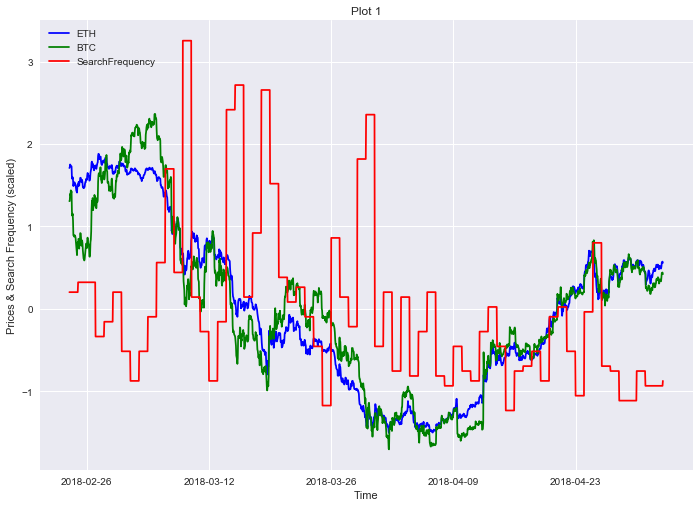

In [19]:
# Plot 1- scaled overlay plot of ETC/BTC prices and GoogleNews search frequency data

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_context("poster")
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.plot(story_combined_scaled.index, story_combined_scaled['ETH'], color='blue')
plt.plot(story_combined_scaled.index, story_combined_scaled['BTC'], color='green')
plt.plot(story_combined_scaled.index, story_combined_scaled['SearchFrequency'], color='red')

plt.legend(loc='upper left')
plt.xlabel('Time')
plt.ylabel('Prices & Search Frequency (scaled)')
plt.title('Plot 1')
plt.show()

Plot shows :-
Sharp rises in search frequency are coupled with price drops
BTC and ETH prices tend to converge during drops, and not spikes (notice that the series were scaled) 

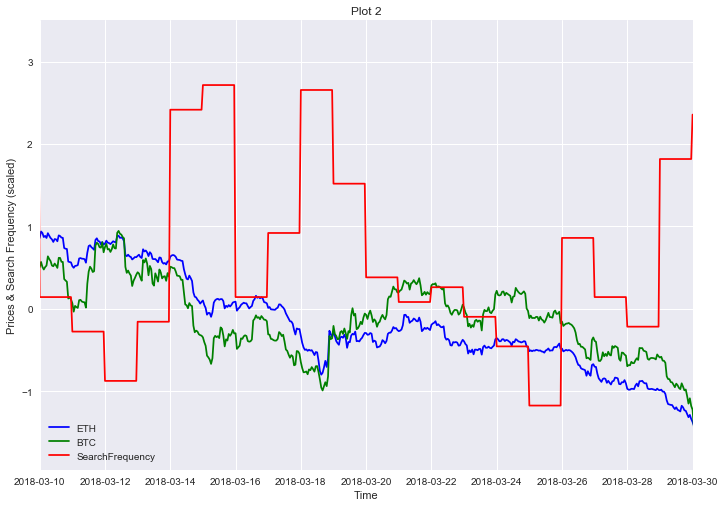

In [18]:
# Plot 2- scaled overlay plot of ETC/BTC prices and GoogleNews search frequency data in 20 days timespand (during drop)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_context("poster")
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.plot(story_combined_scaled.index, story_combined_scaled['ETH'], color='blue')
plt.plot(story_combined_scaled.index, story_combined_scaled['BTC'], color='green')
plt.plot(story_combined_scaled.index, story_combined_scaled['SearchFrequency'], color='red')
plt.xlim(('2018-03-10', '2018-03-30'))
plt.legend(loc='lower left')
plt.xlabel('Time')
plt.ylabel('Prices & Search Frequency (scaled)')
plt.title('Plot 2')
plt.show()

Plot 2 shows that sharp rise in search frequency leads ETH/BTC price drop. However, this conclusion is based on just 2 events

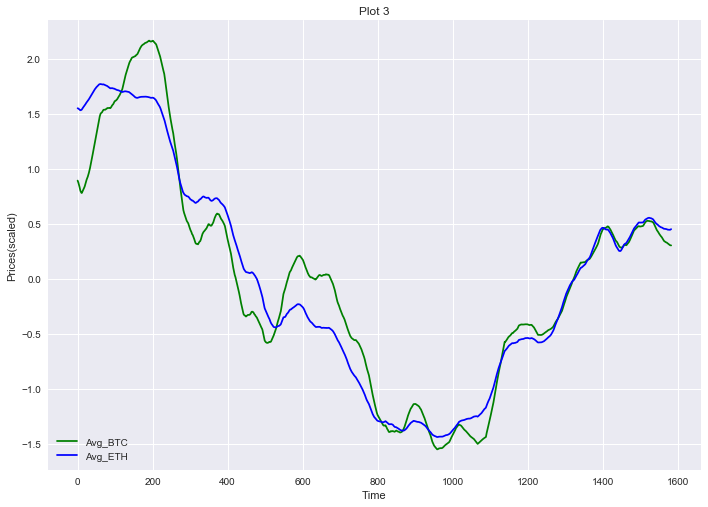

In [20]:
# Plot 3- BTC/ETH moving averages (scaled)

import numpy as np
a = 50
b = a-1
def moving_average(a, n):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
import seaborn as sns
sns.set()
sns.set_context("poster")
sns.set(rc={'figure.figsize':(11.7,8.27)})

ma_combined = pd.DataFrame()
ma_combined['ETH'] = moving_average(story_combined_scaled['ETH'].values, a)
ma_combined['BTC'] = moving_average(story_combined_scaled['BTC'].values, a)

plt.plot(ma_combined.index, ma_combined['BTC'], color='green', label = 'Avg_BTC')
plt.plot(ma_combined.index, ma_combined['ETH'], color='blue', label = 'Avg_ETH')
plt.legend(loc='lower left')
plt.ylabel('Prices(scaled)')
plt.xlabel('Time')
plt.title('Plot 3')
plt.show()

Based on Plot 3 , there seem to be correlation between ETH and BTC prices and that ETH leads BTC. 

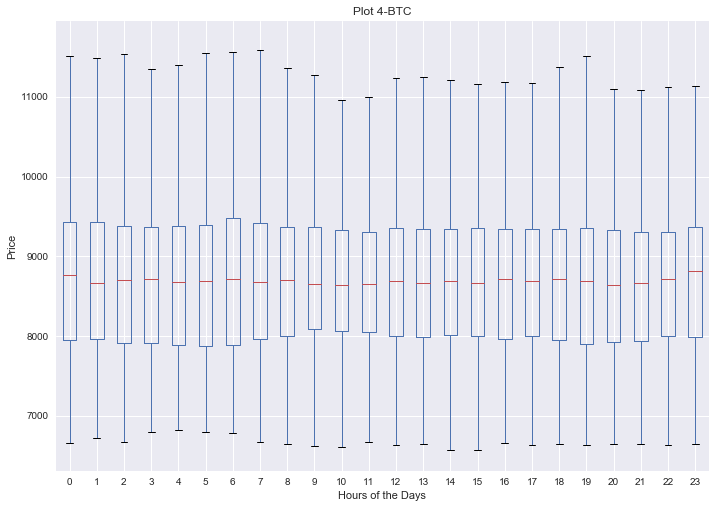

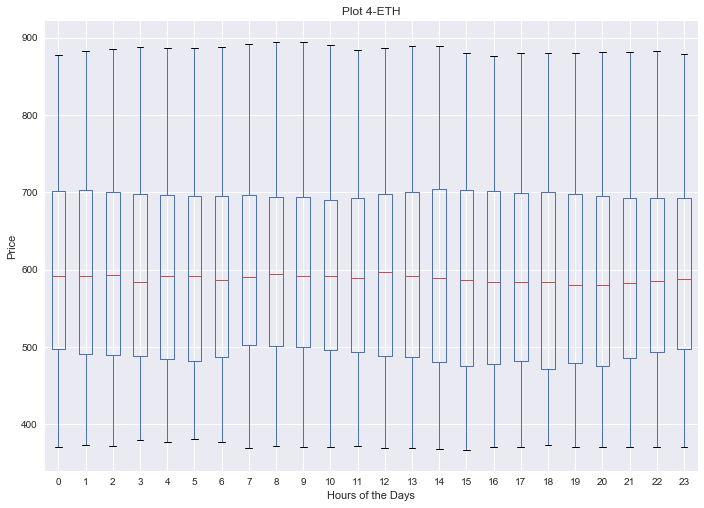

In [21]:
# Plot 4- Box plot by hour of the day

from datetime import datetime, timezone
from collections import OrderedDict
from collections import defaultdict
import seaborn as sns
sns.set()
sns.set_context("poster")
sns.set(rc={'figure.figsize':(11.7,8.27)})

for coin in story_coin:
    group = OrderedDict.fromkeys(story_combined[coin].index.hour)
    group = defaultdict(list)
    for i in story_combined[coin].index:
        group[i.hour].append(story_combined[coin][i])
    lenght = []
    for key in group:
        lenght.append(len(group[key]))
    min_len = min(lenght)
    hour = pd.DataFrame()
    for key, value in group.items():
        hour[key] = value[:min_len]
    hour.boxplot()
    plt.ylabel('Price')
    plt.xlabel('Hours of the Days')
    plt.title('Plot 4-{}'.format(coin), loc='center')
    plt.show()

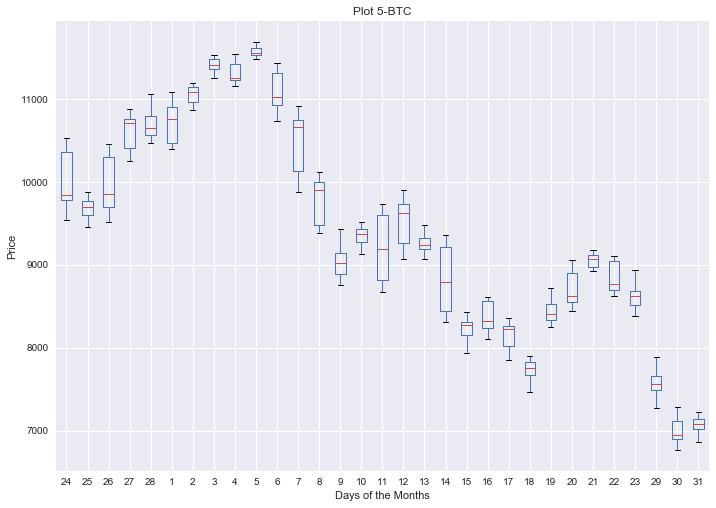

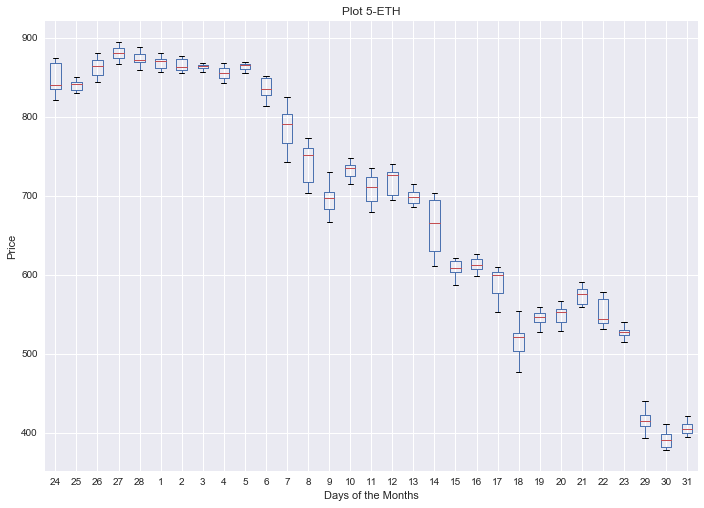

In [22]:
# Plot 5- Box plot by day of the month
import seaborn as sns
sns.set()
sns.set_context("poster")
sns.set(rc={'figure.figsize':(11.7,8.27)})
for coin in story_coin:    
    group = OrderedDict.fromkeys(story_combined[coin].index.day)
    group = defaultdict(list)
    for i in story_combined[coin].index:
        group[i.day].append(story_combined[coin][i])
    lenght = []
    for key in group:
        lenght.append(len(group[key]))
    min_len = min(lenght)
    day = pd.DataFrame()
    for key, value in group.items():
        day[key] = value[:min_len]
    

    day.boxplot()
    plt.ylabel('Price')
    plt.xlabel('Days of the Months')
    plt.title('Plot 5-{}'.format(coin), loc='center')
    plt.show()

Plot 4 shows relatively constant mean, but varying variance throughout hours of the day. However, there's no common patterns observed between BTC and ETH prices stats, which leads me to belive seasonality doesn't exist in these series.

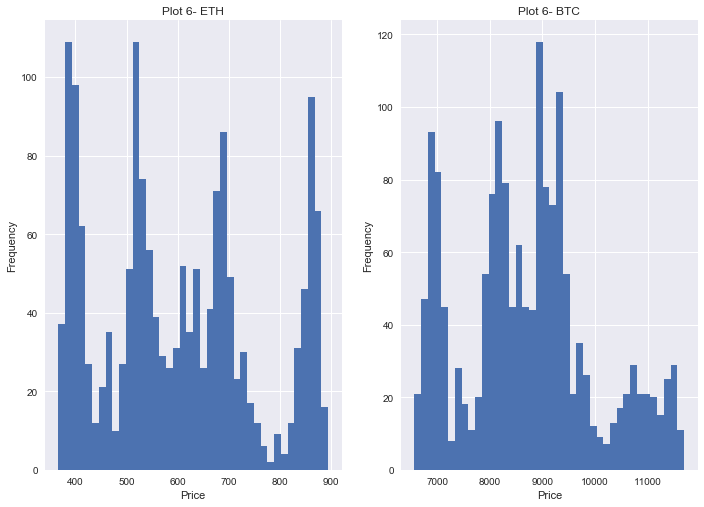

In [23]:
# Plot 6- BTC/ETH histogram

import seaborn as sns
sns.set()
sns.set_context("poster")
sns.set(rc={'figure.figsize':(11.7,8.27)})

n_data = len(story_combined['ETH'])
n_bins = int(np.sqrt(n_data))
plt.subplot(1, 2, 1)
story_combined['ETH'].hist(bins=n_bins)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Plot 6- ETH', loc='center')
plt.subplot(1, 2, 2)
story_combined['BTC'].hist(bins=n_bins)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Plot 6- BTC', loc='center')
plt.show()

Plot 4 shows that ETH has a sharp frequency peak at ~400, while BTC doesn't have such sharp peak. 

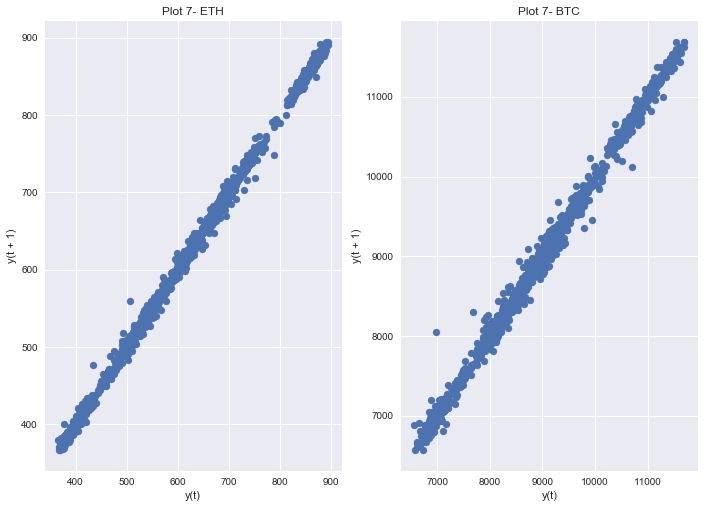

In [24]:
# Plot 7- BTC/ETH lag1 scatter plot
import seaborn as sns
sns.set()
sns.set_context("poster")
sns.set(rc={'figure.figsize':(11.7,8.27)})

from pandas.plotting import lag_plot
plt.subplot(1, 2, 1)
lag_plot(story_combined['ETH'])
plt.title('Plot 7- ETH', loc='center')
plt.subplot(1, 2, 2)
lag_plot(story_combined['BTC'])
plt.title('Plot 7- BTC', loc='center')
plt.show()

Plot 5 suggests positive correlation between observations and their consecutive observations (y_t and y_t-1) in both BTC and ETH. To further explore the series, we're going to look at Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots which measure the linear predictability of the series at time t, say x_t, using the value x_s, where s and t denote two valuation points in time. Before we explore ACF and PACF plots, we need to stationarize the series.

In [25]:
# Result 1- Perform Dickey Fuller Test to determine stationality of BTC and ETC time series

from statsmodels.tsa.stattools import adfuller
x = story_combined['ETH'].values
DF_ETH = adfuller(x)
print('\n')
print('\033[1m' + 'Result 1' + '\033[0m')
print('ADF Statistic (ETH): %f' % DF_ETH[0])
print('p-value: %f' % DF_ETH[1])
print('Critical Values:')
for key, value in DF_ETH[4].items():
    print('\t%s: %.3f' % (key, value))

y = story_combined['BTC'].values
DF_BTC = adfuller(y)
print('\n')
print('ADF Statistic (BTC): %f' % DF_BTC[0])
print('p-value: %f' % DF_BTC[1])
print('Critical Values:')
for key, value in DF_BTC[4].items():
    print('\t%s: %.3f' % (key, value))
print('\n')



Result 1
ADF Statistic (ETH): -1.515960
p-value: 0.525602
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


ADF Statistic (BTC): -1.667106
p-value: 0.448135
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568




C:\Users\mohan\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


From Result 1 above, Dickey-Fuller test shows that both ETH and BTC are NOT stationary series. To stationarize the series, we're going to perform differencing. There are combinations of lag difference and difference order we could pick from. First, we're going to take the difference using lag 1 order 1 on both series.

In [48]:
# Perfrom differencing to stationalize the series

# create a differenced series, with default value of lag 1
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# difference the dataset
diff_BTC = difference(story_combined['BTC'])
diff_ETH = difference(story_combined['ETH'])

diff_2 = difference(story_combined['ETH'], 2)
diff_24 = difference(story_combined['ETH'], 24)



In [49]:
# Result 2- Perfrom Dickey-Fuller Test on the differenced series

DF_diff_BTC = adfuller(diff_BTC)
print('\n')
print('\033[1m' + 'Result 2' + '\033[0m')
print('ADF Statistic (BTC): %f' % DF_diff_BTC[0])
print('p-value: %f' % DF_diff_BTC[1])
print('Critical Values:')
for key, value in DF_diff_BTC[4].items():
    print('\t%s: %.3f' % (key, value))
    
    
DF_diff_ETH = adfuller(diff_ETH)
print('\n')
print('ADF Statistic (ETH): %f' % DF_diff_ETH[0])
print('p-value: %f' % DF_diff_ETH[1])
print('Critical Values:')
for key, value in DF_diff_ETH[4].items():
    print('\t%s: %.3f' % (key, value))
print('\n')



Result 2
ADF Statistic (BTC): -20.997368
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


ADF Statistic (ETH): -13.190008
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568




Based on Result 2, differencing using lag 1 order 1 improved the stationarity. Both BTC and ETH are now stationary series.

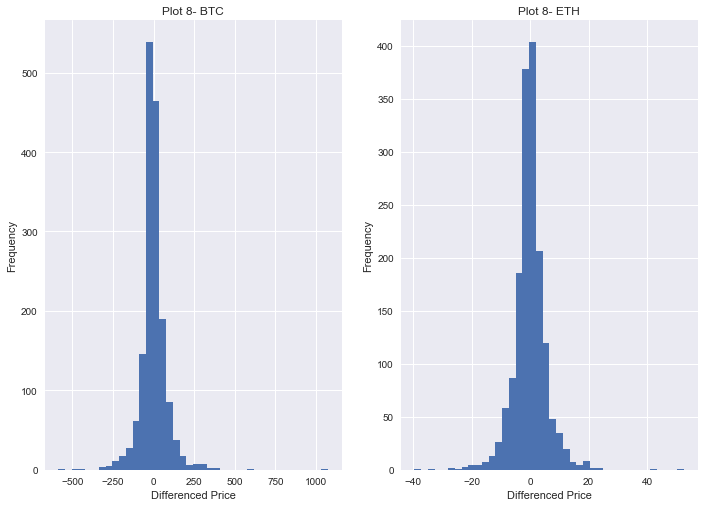

In [28]:
# Plot8- Plotting Histogram of differenced series
import seaborn as sns
sns.set()
sns.set_context("poster")
sns.set(rc={'figure.figsize':(11.7,8.27)})
n_data = len(diff_ETH)
n_bins = int(np.sqrt(n_data))
plt.subplot(1, 2, 1)
plt.hist(diff_BTC, bins=n_bins)
plt.ylabel('Frequency')
plt.xlabel('Differenced Price')
plt.title('Plot 8- BTC', loc='center')
plt.subplot(1, 2, 2)
plt.hist(diff_ETH, bins=n_bins)
plt.ylabel('Frequency')
plt.xlabel('Differenced Price')
plt.title('Plot 8- ETH', loc='center')
plt.show()

Histogram of the difference, Plot 6, shows that the distribution is skewed left. This distribution implies that spiking is more "rapid" than falling. Threshold based on standard deviation of this plot could be used to define "stability" of the series.

In [41]:
# Result 3- Perfrom Granger Causality Test with the null hypothesis of ETH doesn't Granger cause BTC

import statsmodels.tsa.stattools as sm
diff_BTC_ETH = pd.DataFrame()
diff_BTC_ETH['BTC'] = diff_BTC
diff_BTC_ETH['ETH'] = diff_ETH
print('Result 3')
cor = sm.grangercausalitytests(diff_BTC_ETH, 50)

Result 3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5587  , p=0.0060  , df_denom=1628, df_num=1
ssr based chi2 test:   chi2=7.5726  , p=0.0059  , df=1
likelihood ratio test: chi2=7.5551  , p=0.0060  , df=1
parameter F test:         F=7.5587  , p=0.0060  , df_denom=1628, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.1902  , p=0.0153  , df_denom=1625, df_num=2
ssr based chi2 test:   chi2=8.4062  , p=0.0149  , df=2
likelihood ratio test: chi2=8.3846  , p=0.0151  , df=2
parameter F test:         F=4.1902  , p=0.0153  , df_denom=1625, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.4979  , p=0.0150  , df_denom=1622, df_num=3
ssr based chi2 test:   chi2=10.5389 , p=0.0145  , df=3
likelihood ratio test: chi2=10.5050 , p=0.0147  , df=3
parameter F test:         F=3.4979  , p=0.0150  , df_denom=1622, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.112

likelihood ratio test: chi2=42.2198 , p=0.0862  , df=31
parameter F test:         F=1.3257  , p=0.1092  , df_denom=1538, df_num=31

Granger Causality
number of lags (no zero) 32
ssr based F test:         F=1.2819  , p=0.1351  , df_denom=1535, df_num=32
ssr based chi2 test:   chi2=42.7588 , p=0.0969  , df=32
likelihood ratio test: chi2=42.1975 , p=0.1072  , df=32
parameter F test:         F=1.2819  , p=0.1351  , df_denom=1535, df_num=32

Granger Causality
number of lags (no zero) 33
ssr based F test:         F=1.2402  , p=0.1651  , df_denom=1532, df_num=33
ssr based chi2 test:   chi2=42.7167 , p=0.1198  , df=33
likelihood ratio test: chi2=42.1561 , p=0.1319  , df=33
parameter F test:         F=1.2402  , p=0.1651  , df_denom=1532, df_num=33

Granger Causality
number of lags (no zero) 34
ssr based F test:         F=1.2264  , p=0.1744  , df_denom=1529, df_num=34
ssr based chi2 test:   chi2=43.5789 , p=0.1257  , df=34
likelihood ratio test: chi2=42.9953 , p=0.1386  , df=34
parameter F test:

In [42]:
# Result 4- Perform Granger Causality Test with the null hypothesis of BTC doesn't Granger cause ETH

diff_ETH_BTC = pd.DataFrame()
diff_ETH_BTC['ETH'] = diff_ETH
diff_ETH_BTC['BTC'] = diff_BTC
print('Result 4')
cor = sm.grangercausalitytests(diff_ETH_BTC, 50)

Result 4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9676  , p=0.1609  , df_denom=1628, df_num=1
ssr based chi2 test:   chi2=1.9713  , p=0.1603  , df=1
likelihood ratio test: chi2=1.9701  , p=0.1604  , df=1
parameter F test:         F=1.9676  , p=0.1609  , df_denom=1628, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1091  , p=0.3301  , df_denom=1625, df_num=2
ssr based chi2 test:   chi2=2.2250  , p=0.3287  , df=2
likelihood ratio test: chi2=2.2235  , p=0.3290  , df=2
parameter F test:         F=1.1091  , p=0.3301  , df_denom=1625, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9723  , p=0.4049  , df_denom=1622, df_num=3
ssr based chi2 test:   chi2=2.9294  , p=0.4026  , df=3
likelihood ratio test: chi2=2.9267  , p=0.4031  , df=3
parameter F test:         F=0.9723  , p=0.4049  , df_denom=1622, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.401

likelihood ratio test: chi2=37.3697 , p=0.1997  , df=31
parameter F test:         F=1.1717  , p=0.2374  , df_denom=1538, df_num=31

Granger Causality
number of lags (no zero) 32
ssr based F test:         F=1.1292  , p=0.2841  , df_denom=1535, df_num=32
ssr based chi2 test:   chi2=37.6654 , p=0.2259  , df=32
likelihood ratio test: chi2=37.2289 , p=0.2409  , df=32
parameter F test:         F=1.1292  , p=0.2841  , df_denom=1535, df_num=32

Granger Causality
number of lags (no zero) 33
ssr based F test:         F=1.1116  , p=0.3046  , df_denom=1532, df_num=33
ssr based chi2 test:   chi2=38.2865 , p=0.2420  , df=33
likelihood ratio test: chi2=37.8353 , p=0.2580  , df=33
parameter F test:         F=1.1116  , p=0.3046  , df_denom=1532, df_num=33

Granger Causality
number of lags (no zero) 34
ssr based F test:         F=1.0815  , p=0.3442  , df_denom=1529, df_num=34
ssr based chi2 test:   chi2=38.4290 , p=0.2758  , df=34
likelihood ratio test: chi2=37.9742 , p=0.2930  , df=34
parameter F test:

Based on Result 3-4, it's most likely that BTC causes ETH. From ~lag 4 to ~lag 16 (4-16 hours), we observed >99% confidence level. On the other hand, Granger Test failed to prove that ETH causes BTC(failed to reject the null hypothesis). However, the p values improve beyond ~lag 50 (~2days), with confidence level of ~90%.

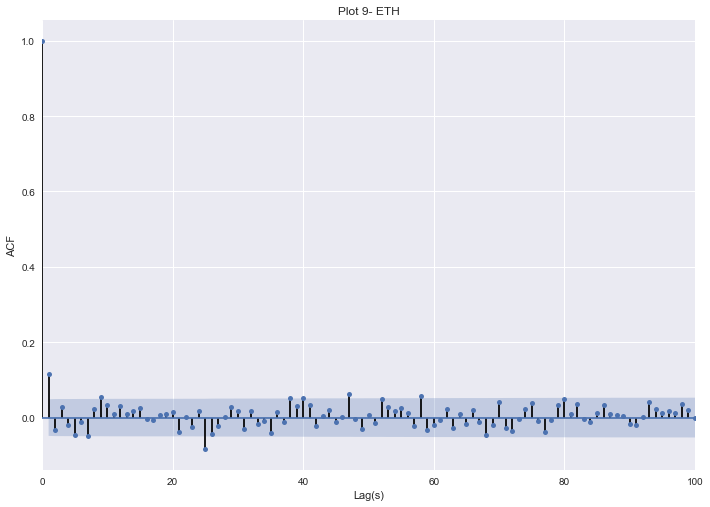

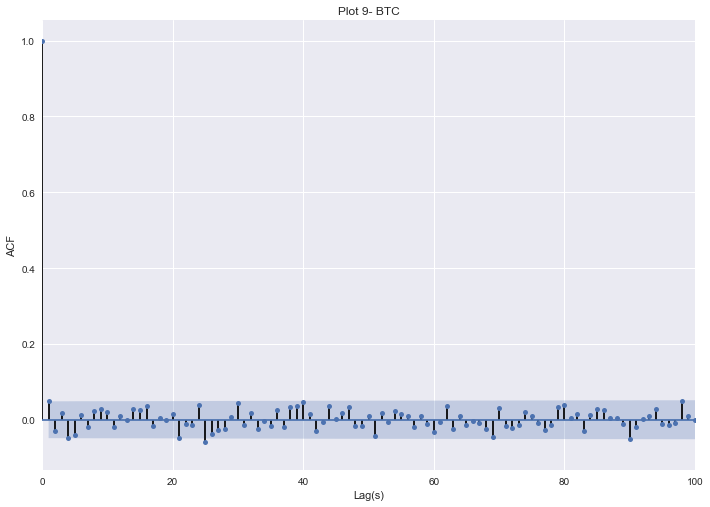

In [44]:
# Plot 9- ACF plot of the differenced series using lag 1 order 1

from statsmodels.graphics.tsaplots import plot_acf
from pandas import tseries
sns.set()
sns.set_context("poster")
sns.set(rc={'figure.figsize':(11.7,8.27)})
plot_acf(diff_ETH)
plt.title('Plot 9- ETH', loc='center')
plt.xlim((0, 100))
plt.ylabel('ACF')
plt.xlabel('Lag(s)')
plot_acf(diff_BTC)
plt.title('Plot 9- BTC', loc='center')
plt.xlim((0, 100))
plt.ylabel('ACF')
plt.xlabel('Lag(s)')
plt.show()

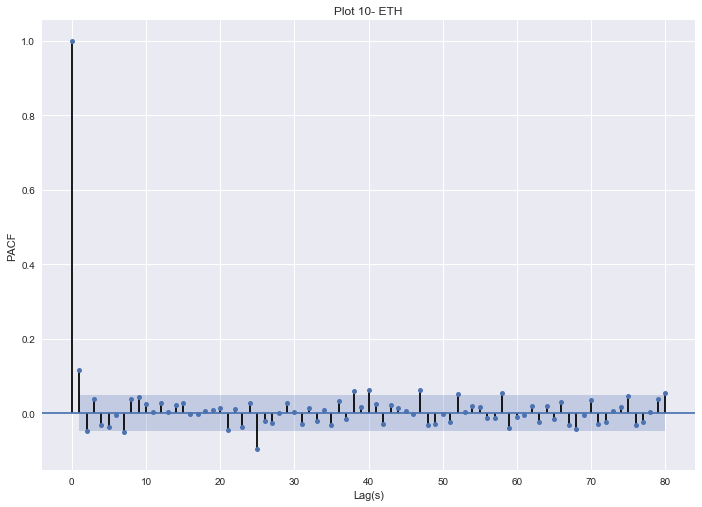

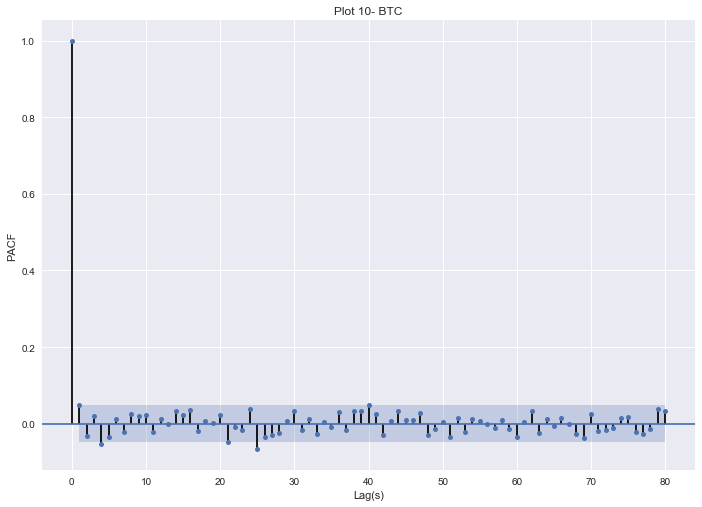

In [45]:
# Plot 10- PACF plot of the differenced series using lag 1 order 1

from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf
sns.set()
sns.set_context("poster")
sns.set(rc={'figure.figsize':(11.7,8.27)})

plot_pacf(diff_ETH, lags=80)
plt.title('Plot 10- ETH', loc='center')
plt.ylabel('PACF')
plt.xlabel('Lag(s)')

plot_pacf(diff_BTC, lags=80)
plt.title('Plot 10- BTC', loc='center')
plt.ylabel('PACF')
plt.xlabel('Lag(s)')
plt.show()

Since there combinations of lag difference and difference order we could pick from, the following sections explore the combinations.



ADF Statistic: -8.541669
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


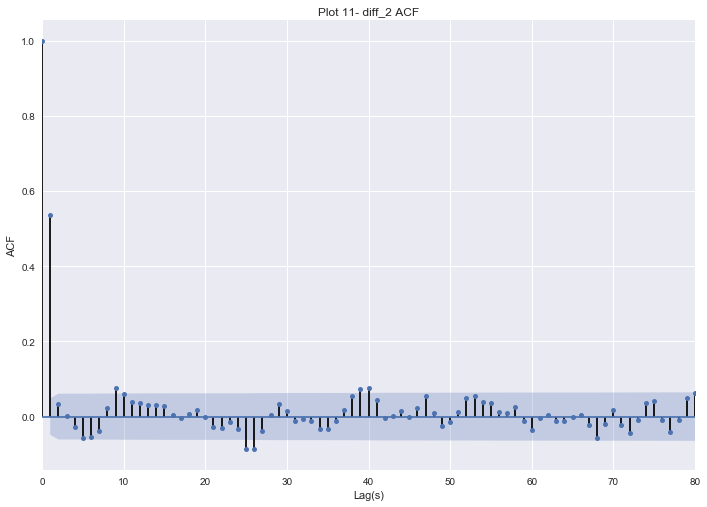

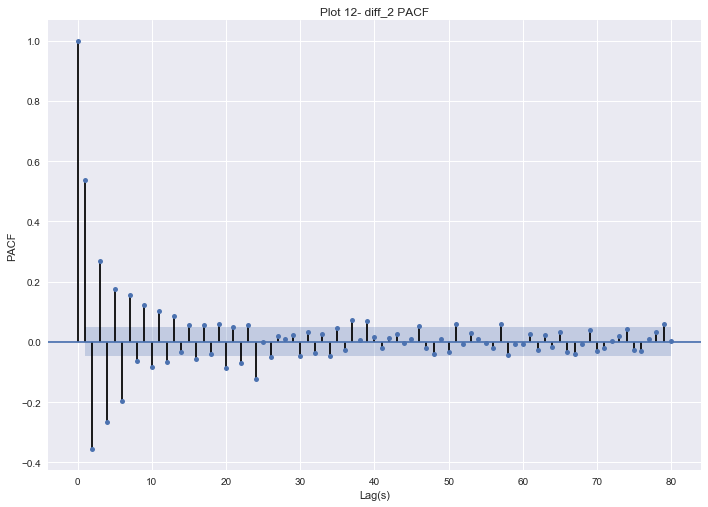

In [46]:
# Dickey Fuller Test result, ACF, and PACF plots of differenced series using
# Lag 2 order 1

DF_diff_2 = adfuller(diff_2)
print('\n')
print('ADF Statistic: %f' % DF_diff_2[0])
print('p-value: %f' % DF_diff_2[1])
print('Critical Values:')
for key, value in DF_diff_2[4].items():
    print('\t%s: %.3f' % (key, value))
    
plot_acf(diff_2)
plt.title('Plot 11- diff_2 ACF', loc='center')
plt.ylabel('ACF')
plt.xlabel('Lag(s)')
plt.xlim([0, 80])
plt.show()

plot_pacf(diff_2, lags=80)
plt.title('Plot 12- diff_2 PACF', loc='center')
plt.ylabel('PACF')
plt.xlabel('Lag(s)')    
plt.show()



ADF Statistic: -4.509031
p-value: 0.000189
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


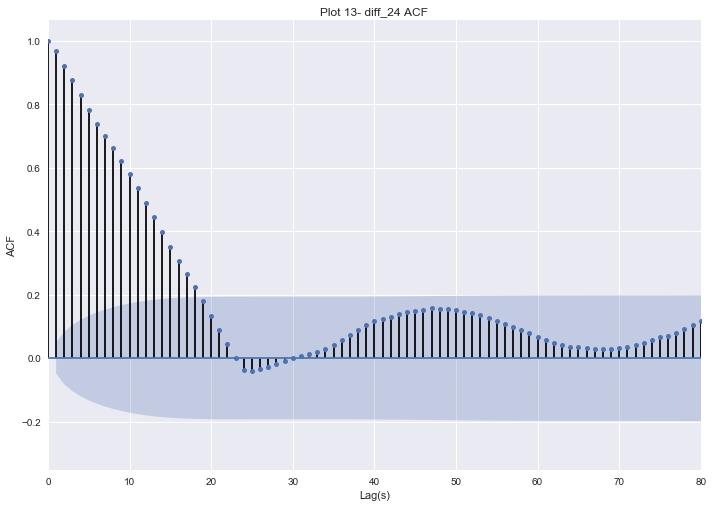

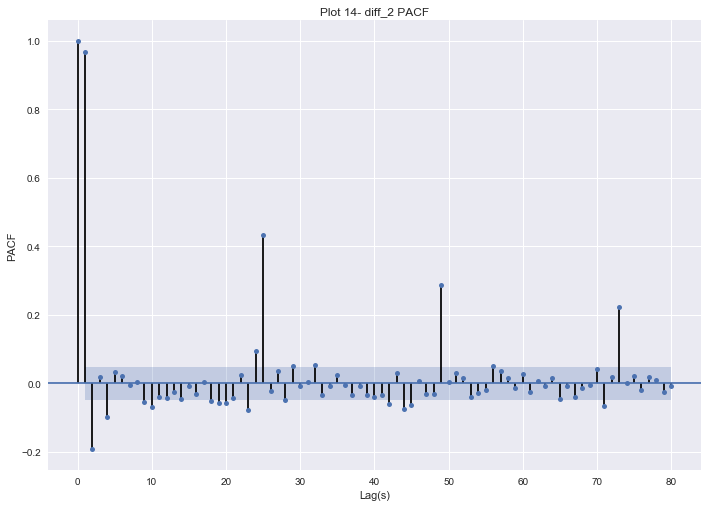

In [47]:
# Dickey Fuller Test result, ACF, and PACF plots of differenced series using 
# lag 2 order 1

DF_diff_24 = adfuller(diff_24)
print('\n')
print('ADF Statistic: %f' % DF_diff_24[0])
print('p-value: %f' % DF_diff_24[1])
print('Critical Values:')
for key, value in DF_diff_24[4].items():
    print('\t%s: %.3f' % (key, value))
    
plot_acf(diff_24)
plt.title('Plot 13- diff_24 ACF', loc='center')
plt.ylabel('ACF')
plt.xlabel('Lag(s)')
plt.xlim([0, 80])
plt.show()

plot_pacf(diff_24, lags=80)
plt.title('Plot 14- diff_2 PACF', loc='center')
plt.ylabel('PACF')
plt.xlabel('Lag(s)')    
plt.show()

Conclusion:
1. There seem to be high correlation between the rise in search frequency and the drop in currencies prices 
2. High correlation between BTC and ETH ( >99% confidence level )
3. There is a low correlation between an observation and it's lag 1 (x_t and x_t-1)
4. Both series have no obvious trends or seasonalities
5. Spike is more "rapid" than fall
6. BTC and ETH prices (scaled) converged during fall, but not spike 

From the above analysis, I come to the conclusion that cyrpto time series analysis ( historical prices alone) might be insufficent when predicting such volatile markets. 

Using Machine Learning with variety of predictorss will improve prediction model significantly. 